In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from statistics import mean
import math
import cloudpickle
import gzip
import matplotlib as mpl

from math import log

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams.update({'figure.max_open_warning': 0,'font.size': 14,'axes.titlesize': 14,'axes.labelsize': 14,
                 'axes.grid':True,'xtick.direction': 'in','ytick.direction': 'in','ytick.right': True,
                 'xtick.top':True,'ytick.major.size': 10,'xtick.major.size': 10,'legend.fancybox': True,
                 'legend.markerscale': 0.8,'legend.handlelength': 5.0
                 #'axes.prop_cycle': cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']),                 
                 #'xtick.labelsize': 12,
                 #'ytick.labelsize': 12
                })

#from cycler import cycler
mpl.rcParams['grid.linestyle'] = '-.'
#rcParams.keys() 
#plt.style.use('dark_background')
#print(plt.style.available)


In [3]:
dirname = '/home/furkan/work/flicanalyzer/pypuca/dune/pods/'
hists={}
allArrays = np.array([])
for filename in sorted(os.listdir(dirname)):
    if '.pkl.gz' in filename:
            with gzip.open(dirname+filename,'rb') as fin:
                mydata = pickle.load(fin)
                
                for k in mydata.keys():
                    if 'channel_132'==k:

                        if k in hists: 
                            #allArrays  = np.concatenate((hists[k], mydata[k]))
                             hists.update({k: np.concatenate((hists[k], mydata[k]))  })
                            #allArrays  = np.concatenate((hists[k], mydata[k]))
                        else: hists[k] = mydata[k]

                    #mydata = pickle.load(fin)
                    #np.concatenate((array2D_1, array2D_2))


In [4]:
hists['channel_132'].shape

(34418, 2000)

In [9]:
import scipy.integrate as integrate

data=hists['channel_132']
integArr = np.array([])
for row in data:
    baseline = [0:row.size, 800:1050].mean(axis=1)
    indata= row[1060:1350,]
    result_simps = integrate.simps(indata)
    #print(result_simps)
    integArr = np.append(integArr, result_simps)
    #print(integArr.shape)
    #plt.plot(integArr)
from scipy.stats import norm

plt.hist(integArr, bins=600, density=True, facecolor='g', alpha=0.75, label='channel_132')
#sns.distplot(integArr, kde=True)
#sns.distplot(integArr,fit=stats.maxwell)

#plt.yscale('log')
plt.grid(True)
plt.xlim(-10000, 5000000)

plt.legend(labelspacing=1, fontsize='x-large')  # To draw legend
plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)

plt.show()



SyntaxError: invalid syntax (<ipython-input-9-65f04ac2da63>, line 6)

In [10]:
with gzip.open('concatenate.pkl.gz', 'wb') as fout:
    cloudpickle.dump(hists, fout)

In [11]:
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy import signal

select_dict = {}

for key in hists:
    regression_arary = np.array([])
    
    for row in hists[key]:
        
        x = np.arange(len(row))
        # lowpass filter
        b, a = signal.butter(3, 0.05)
        zi = signal.lfilter_zi(b, a)
        z, _ = signal.lfilter(b, a, row, zi=zi*row[0])
        z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
        y = signal.filtfilt(b, a, row)
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        trend=np.absolute(slope)
        mask=[trend < 0.01 ]
    
        regression_arary = np.append(regression_arary, mask, axis=0)
        regression_arary=regression_arary > 0
        
    evtselect=hists[key][regression_arary]
    print(key,evtselect.shape)
    

    gauss=gaussian_filter(evtselect, sigma=1)
    baseline = evtselect[0:gauss.size, 800:1050].mean(axis=1)
    #print(arr.size)
    #Nevent = (baseline.size)
    #print('nevent', Nevent)
    blines = baseline.reshape(baseline.size, 1) 
    select_dict.update({key: evtselect-blines})


channel_132 (34077, 2000)


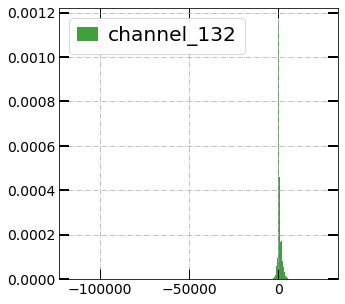

In [12]:
import scipy.integrate as integrate
import seaborn as sns
from scipy.signal import find_peaks

rcParams['figure.figsize'] = 5, 5
rcParams["legend.markerscale"] = 1
rcParams["legend.handlelength"] = 1.0
rcParams["legend.handletextpad"] = 0.5
import os




for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
        #print(integArr.shape)
        #plt.plot(integArr)
    from scipy.stats import norm

    plt.hist(integArr, bins=600, density=True, facecolor='g', alpha=0.75, label=key)
    #sns.distplot(integArr, kde=True)
    #sns.distplot(integArr,fit=stats.maxwell)

    #plt.yscale('log')
    plt.grid(True)
    #plt.xlim(-100, 10000)

    plt.legend(labelspacing=1, fontsize='x-large')  # To draw legend
    plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
    plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
    plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)

    plt.show()
    

    

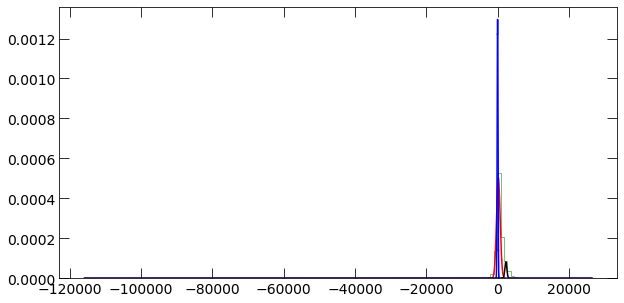

In [13]:
from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.ticker as tkr
import scipy.stats as stats

rcParams['figure.figsize'] = 10, 5

for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
        #print(integArr.shape)
        #plt.plot(integArr)
    
    sample=integArr
    f = np.ravel(sample).astype(np.float)
    f=f.reshape(-1,1)
    g = mixture.GaussianMixture(n_components=4,covariance_type="full",)
    g.fit(f)
    g1 = mixture.GaussianMixture(n_components=8,covariance_type="full",)
    g1.fit(f)
    g2 = mixture.GaussianMixture(n_components=20,covariance_type="full",)
    g2.fit(f)
    weights = g.weights_
    means = g.means_
    covars = g.covariances_
    #print('w',weights, 'm', means, 'cov', covars)
    
    weights1 = g1.weights_
    means1 = g1.means_
    covars1 = g1.covariances_
    
    weights2 = g2.weights_
    means2 = g2.means_
    covars2 = g2.covariances_
    
    plt.hist(f, bins=150, histtype='step', density=True, ec='g', alpha=0.5)
    
    f_axis = f.copy().ravel()
    f_axis.sort()
    plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')
    plt.plot(f_axis,weights1[0]*stats.norm.pdf(f_axis,means1[0],np.sqrt(covars1[0])).ravel(), c='blue')
    plt.plot(f_axis,weights2[0]*stats.norm.pdf(f_axis,means2[0],np.sqrt(covars2[0])).ravel(), c='black')
   
    plt.rcParams['agg.path.chunksize'] = 10000
    plt.grid()
    plt.show()

In [14]:
import scipy.integrate as integrate
import seaborn as sns
from scipy.signal import find_peaks

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}
import os
from scipy.stats import norm



for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
    print(integArr.shape)
    # reshape
        #plt.plot(integArr)




(34077,)


[ 20168.072        5710.93266667   5834.88466667  18431.22133333
   8233.47466667  32466.35         5111.59866667   8619.54266667
  20817.73666667  23366.57666667  10520.57066667  11201.16066667
   9694.714       39095.48933333   6741.756       12600.27
  59220.488       41684.01666667  17796.096        6621.318
  19573.29066667  13798.392       23038.18733333  18681.31933333
  58735.092       13718.96733333   8932.772        8301.26866667
  44955.912        7314.67733333 112255.56666667   7002.19266667
  11564.10933333  16492.51533333  12667.638       23089.14
   3843.97533333  44873.278        3138.79266667   9225.722
   6140.9          9638.74933333  24466.24666667   6002.15533333
   9391.73266667   3103.372        6599.558        3325.81666667
  20306.35666667   6094.33266667   4391.56866667]
[  88.67938628   13.76130393   11.20520745   20.69834503   48.47859623
  172.68519892   12.42494868   29.85105724   38.53468152   17.71034399
   69.40907145   54.36350375  107.7231689   940.63

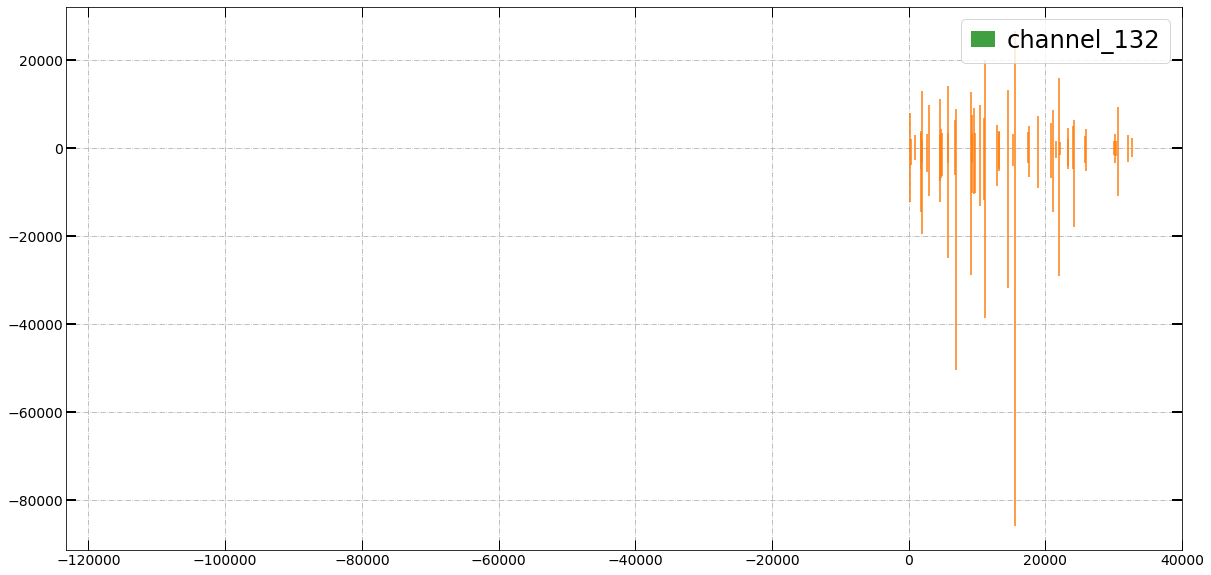

In [15]:
import scipy.integrate as integrate
import seaborn as sns
from scipy.signal import find_peaks

rcParams['figure.figsize'] = 20, 10
rcParams["legend.markerscale"] = 1
rcParams["legend.handlelength"] = 1.0
rcParams["legend.handletextpad"] = 0.5


for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
        #print(integArr.shape)
        #plt.plot(integArr)
    peaks, properties = find_peaks(integArr, prominence=1, width=10)
    print(properties["prominences"]) 
    print(properties["widths"])
    
    plt.hist(integArr, bins=300, density=True, facecolor='g', alpha=0.75, label=key)
    #plt.plot(integArr)
    #plt.plot(peaks, integArr[peaks], "x")
    plt.vlines(x=peaks, ymin=integArr[peaks] - properties["prominences"], ymax = integArr[peaks], color = "C1")
    #sns.distplot(integArr)
    #sns.distplot(integArr,fit=stats.maxwell)

    #plt.yscale('log')
    plt.grid(True)
    plt.legend(labelspacing=1, fontsize='xx-large')  # To draw legend
    plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
    plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
    plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)

    plt.show()
    

In [16]:
asdads = savgol_filter(arr, 5, 2, mode='nearest')
asdads

NameError: name 'savgol_filter' is not defined

In [ ]:
baseline = eventSel[0:eventSel.size, 800:1050].mean(axis=1)
#print(arr.size)
#Nevent = (baseline.size)
#print('nevent', Nevent)
blines = baseline.reshape(baseline.size, 1)
clean = eventSel-blines
clean.shape

In [ ]:
for row in clean:
    #print(row)
    plt.plot(row)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
data = clean.mean(axis=0)
plt.plot(data)
plt.grid(True)
#t = np.arange(len(data))
plt.xlim(900, 1600)
#plt.ylim(-5, 200)
plt.show()

In [ ]:
import scipy.integrate as integrate
import scipy.special as special
result = integrate.quad(lambda data: special.jv(2.5,data), 1000, 1400)
result

In [ ]:
import scipy.integrate as integrate

integArr = np.array([])
print(integArr)

for row in clean:

    indata= row[1060:1350,]
    result_simps = integrate.simps(indata)
    #print(result_simps)
    integArr = np.append(integArr, result_simps)

print(integArr.shape)
#plt.plot(integArr)
n, bins, patches = plt.hist(integArr, 200, density=True, facecolor='g', alpha=0.75)

plt.grid(True)
plt.show()

In [ ]:
from scipy import stats
import numpy as np


dataAll=mydata['channel_135']
y=dataAll[ 0:dataAll.size ,0:1100]
x = np.arange(len(y))
print(y(axis=1))
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
#mask=[p_value >0.01 ]
#dataAll[mask,:]

#a

#baseline = arr[0:arr.size, 1:100].mean(axis=1)

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
#x = electrocardiogram()[2000:4000]
x=mydata['channel_135'][39]
test=x[ 0:900]
#print(x)
print('_______')
#print(test)
peaks, _ = find_peaks(test, height=1580)
print(test[peaks].size)
plt.plot(x)
plt.plot(peaks, test[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()


In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][29]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
mask=[p_value >0.01 ]
print(mask)


baseline = arr[0:arr.size, 1:100].mean(axis=1)


In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][39]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
p_value
print(mask)

In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][39]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
mask=[p_value >0.01 ]

#y=None

In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][3]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
mask=[p_value >0.01 ]
print(mask)
mask1=np.array([True, True, False,])
print(mask1)
a[mask1,:]


baseline = arr[0:arr.size, 1:100].mean(axis=1)
print(arr.size)
Nevent = (baseline.size)
print('nevent', Nevent)
blines = baseline.reshape(baseline.size, 1)
clean = arr-blines
clean.shape

In [ ]:
# https://en.wikipedia.org/wiki/QRS_complex
peaks, _ = find_peaks(x, distance=1)
np.diff(peaks)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [ ]:
peaks, properties = find_peaks(x, prominence=(None, 1))
                                 #prominences = peak_prominences(x, peaks)[0]
properties["prominences"].max()
#0.5049999999999999
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()


In [ ]:
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt



peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
prominences
#array([1.24159486, 0.47840168, 0.28470524, 3.10716793, 0.284603  ,
       0.47822491, 2.48340261, 0.47822491])

plt.show()



In [ ]:
>>> plt.plot(x)
>>> plt.plot(peaks, x[peaks], "x")
>>> plt.show()

In [ ]:
rcParams['figure.figsize'] = 20, 10

for x in range(10):
    plt.plot(mydata['channel_135'][x], label=x, linewidth=4)
    plt.title('channel_135')
    plt.title('one event', loc='left')
    plt.title('ProtoDune Preliminary', loc='right')
    plt.grid(True)

    plt.legend(labelspacing=1, fontsize='x-large')  # To draw legend
    plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
    plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
    plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)
plt.show()


In [ ]:
%matplotlib inline
plt.plot(data)
plt.plot(peaks,data[peaks],"x")
plt.plot(np.zeros_like(data),"-",color="gray")
plt.show()

In [ ]:
a = np.array([[1,20,30,40],
              [5,60,70,80],
              [2,10,11,12]])
a.shape

In [ ]:
 a[a[:,0] > 3]
baseline = arr[0:arr.size, 1:100].mean(axis=1)

In [ ]:
mask=np.array([True, True, False,])
print(mask)
a[mask,:] 